# Recolección de datos

Esta parte la puede detallar mejor Jessica

# Preprocesamiento y extracción de características

Una vez que definimos las columnas, o variables, que utilizaremos en la construcción del dataset recurrimos a reglas del negocio para saber como tratar los valores *en blanco* o nulos

In [1]:
''' libraries'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from plotnine import *
''' config notebook ''' 
%matplotlib inline

datos = pd.read_csv('CAToperaciones.csv')
datos.dtypes

CLAVE_CLIENTE           int64
CVE_UNIDAD_NEGOCIO      int64
UNIDAD_NEGOCIO         object
EMISORA_FONDO          object
DESC_CE_FINANCIERO     object
SALDO_CLIENTE         float64
TIPO_OPERACION         object
GENERO                 object
Edad                    int64
ENROLADO               object
dtype: object

No tenemos ningun dato nulo :) de ello cuidamos en la RECOLECCIÓN DE LOS DATOS

In [2]:
datos.isnull().values.any() 

False

In [3]:
del datos['CLAVE_CLIENTE'] # para fines de modelación de momento el i del cliente no se requiere  

Como nuestro objetivo es impulsar la digitalización de la Banca de inversión, excluimos de nuestra muestra a las personas morales por las siguientes:

    - Los clientes de Actinver en su mayoría son personas físicas
    - Las personas morales pueden tener más de una persona que opere sus cuentas por lo que la elección o no de los servicios digitales puede estar comprometida o condicionada por reglas propias de su negocio.



In [4]:
# para excluir a las personas morales, la variable 'GENERO' nos permite identificarlas
print(datos.GENERO.value_counts())
index = datos[ datos['GENERO'] == 'SIN GENERO'].index
datos.drop(index, inplace=True)
datos = datos.reset_index()

FEMENINO      3865
MASCULINO     3657
SIN GENERO      10
Name: GENERO, dtype: int64


# Exploración de los datos

Veamos cómo se distribuyen nuestras variables con relación a variable a predecir, las cuales en su mayoría son categóricas

In [5]:
# colores UP
colores =  np.array(  ['#A4061F', '#CFAB7A', '#00529B'  ])

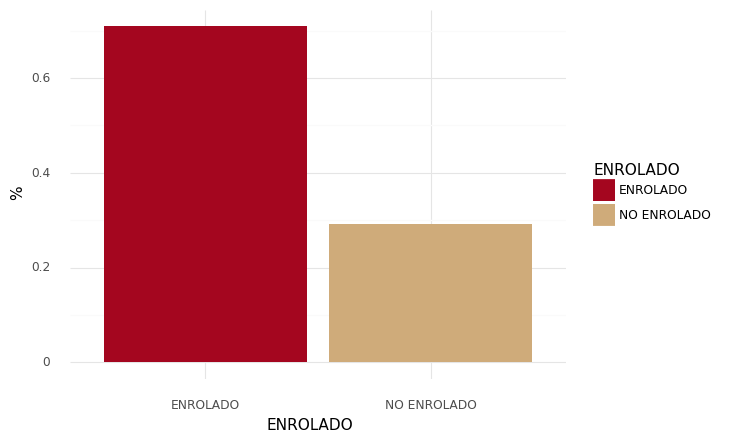

<ggplot: (-9223371926328057900)>

In [6]:
ggplot(datos, aes(x='ENROLADO' , fill='ENROLADO')) + \
     geom_bar(aes(y = '(..count..)/sum(..count..)')) + \
     theme_minimal() + ylab('%') + scale_fill_manual(colores[0:2])

Notamos que la variable `CVE_UNIDAD_NEGOCIO` es la misma que `UNIDAD_NEGOCIO`, por lo que eliminamos la primera

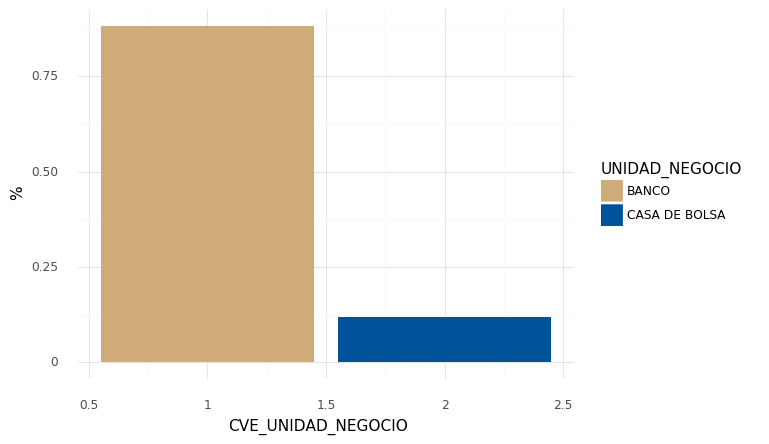

<ggplot: (-9223371926321428608)>

In [7]:
ggplot(datos, aes(x='CVE_UNIDAD_NEGOCIO' , fill='UNIDAD_NEGOCIO')) + \
     geom_bar(aes(y = '(..count..)/sum(..count..)')) + \
     theme_minimal() + ylab('%') + scale_fill_manual(colores[1:3])

In [8]:
del datos['CVE_UNIDAD_NEGOCIO']

106


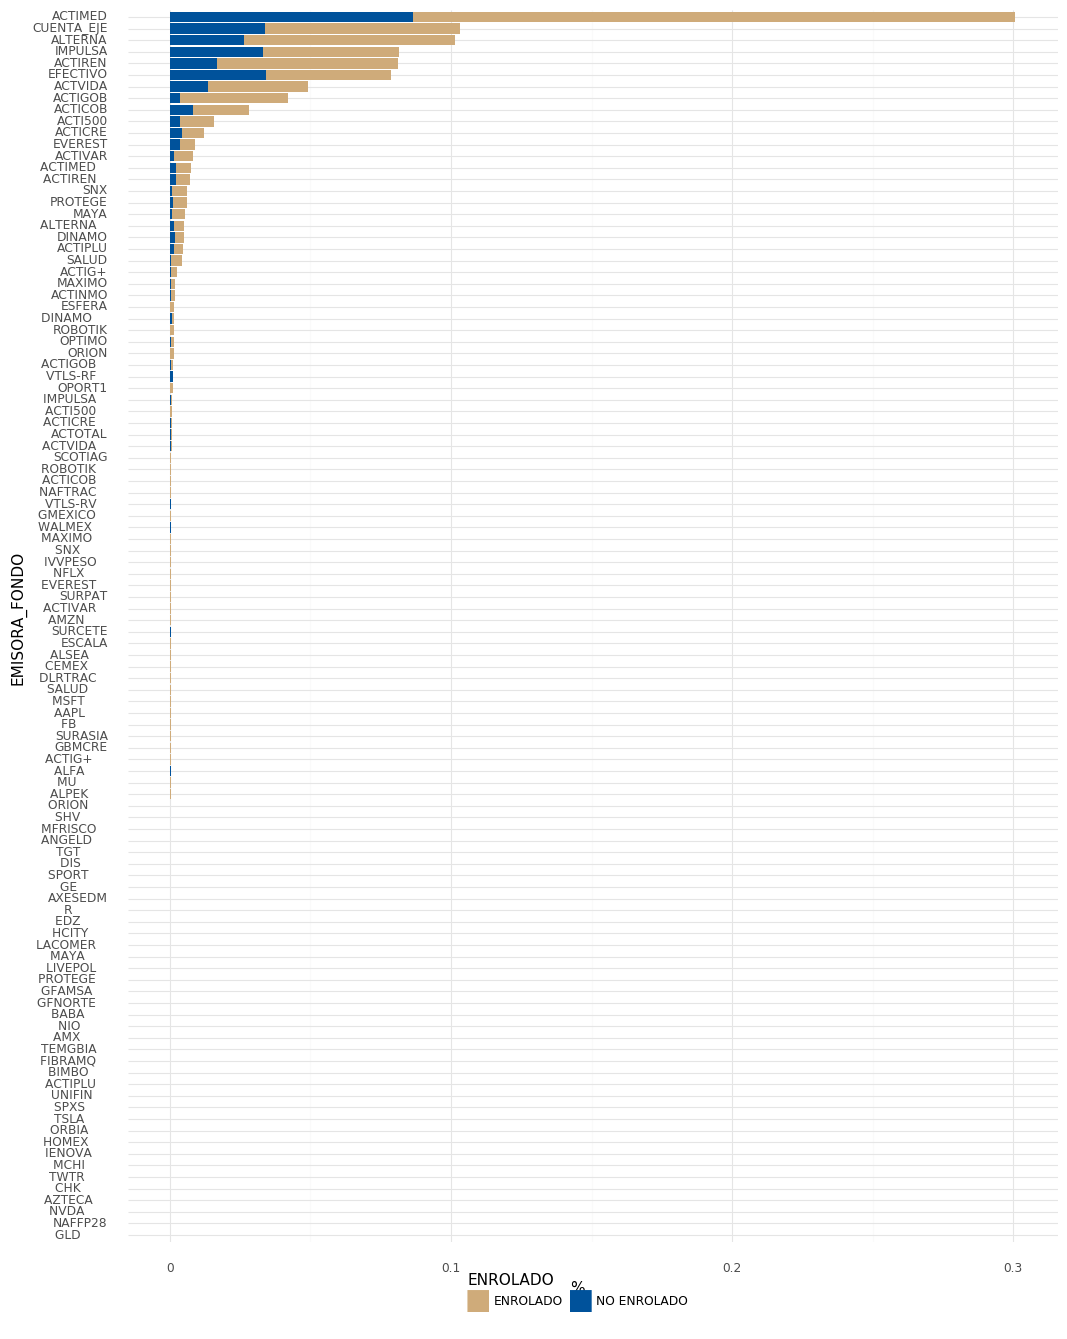

<ggplot: (-9223371926321258976)>

In [9]:
temp = datos['EMISORA_FONDO'].value_counts().index.tolist()[::-1]
print(len(temp))
ggplot(datos) + aes(x='EMISORA_FONDO', y = '(..count..)/sum(..count..)',  fill='ENROLADO')  + geom_bar()  +\
  scale_x_discrete(limits=temp) + ylab('%') + theme_minimal() + \
     theme( legend_position='bottom', figure_size=(12, 16)) + \
     coord_flip() + scale_fill_manual(colores[1:3])
 

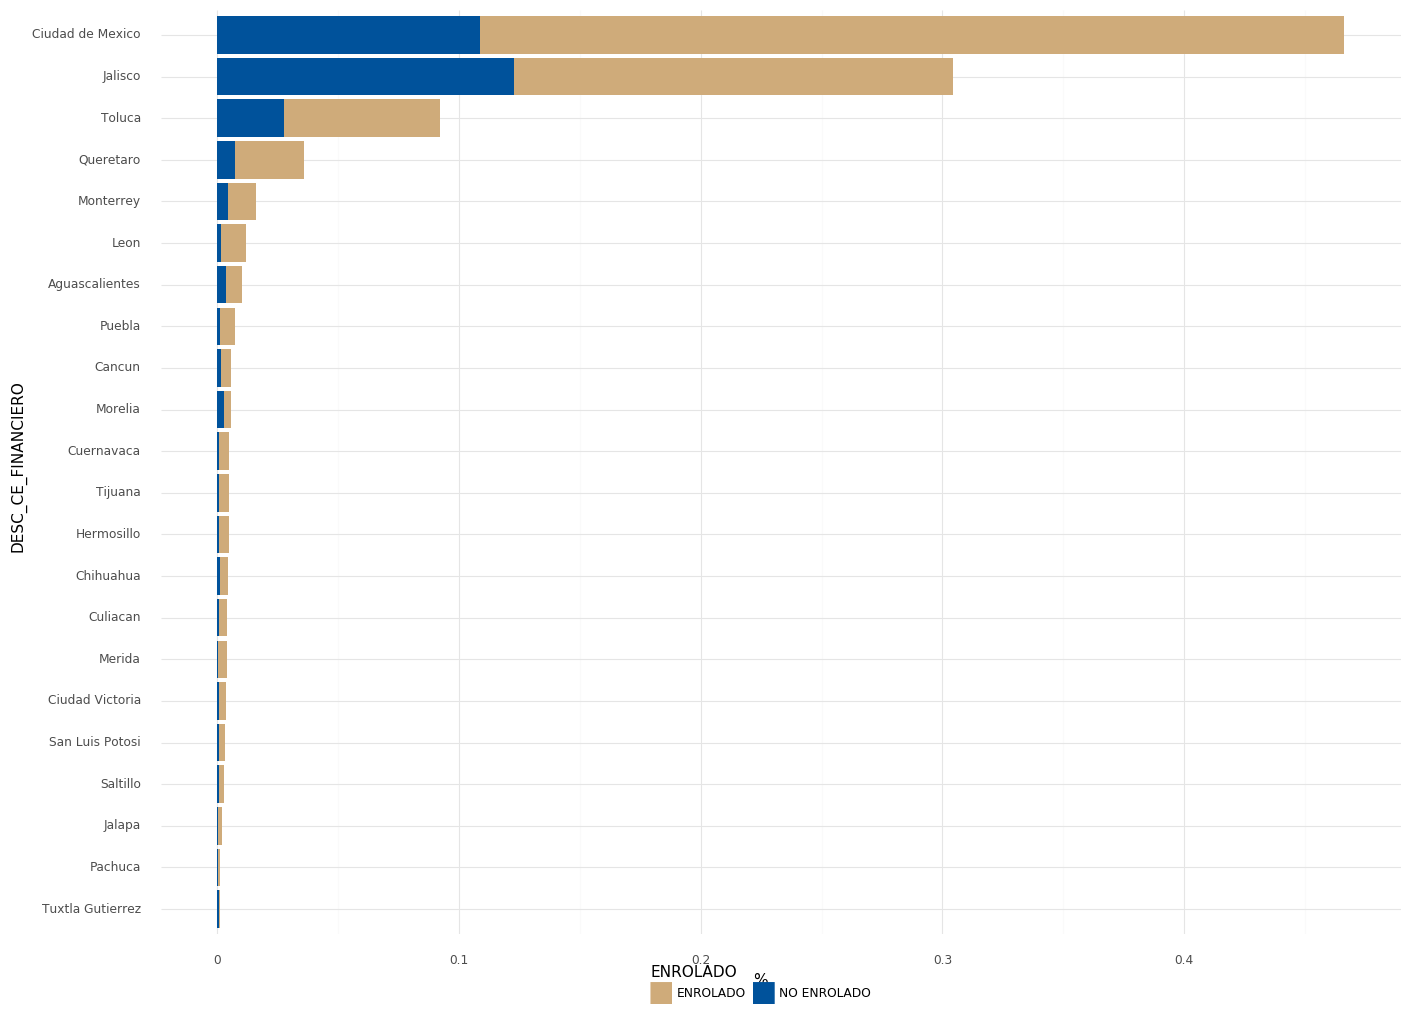

<ggplot: (-9223371926321293628)>

In [10]:
temp = datos['DESC_CE_FINANCIERO'].value_counts().index.tolist()[::-1]
temp
ggplot(datos) + aes(x='DESC_CE_FINANCIERO', y = '(..count..)/sum(..count..)',  fill='ENROLADO')  + geom_bar()  +\
  scale_x_discrete(limits=temp) + ylab('%') + theme_minimal() + \
     theme( legend_position='bottom', figure_size=(16, 12)) + \
     coord_flip() + scale_fill_manual(colores[1:3])

Como es común en las variables que reflejan ingresos, la variable`SALDO_CLIENTE` está sesgada positivamente por lo que trabajaremos en lo subsecuente con su logaritmo natural

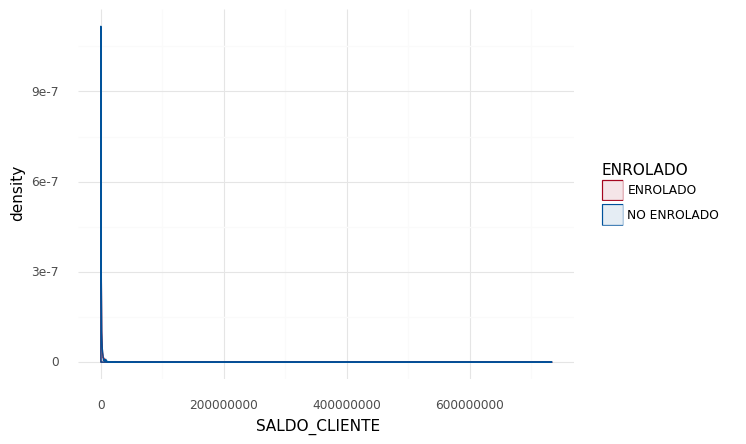

<ggplot: (-9223371926320952220)>

In [11]:
ggplot(datos, aes(x='SALDO_CLIENTE', fill='ENROLADO', color='ENROLADO')) + geom_density( alpha=0.1) + theme_minimal() +\
scale_fill_manual(colores[[0,2]]) + scale_color_manual(colores[[0,2]]) 

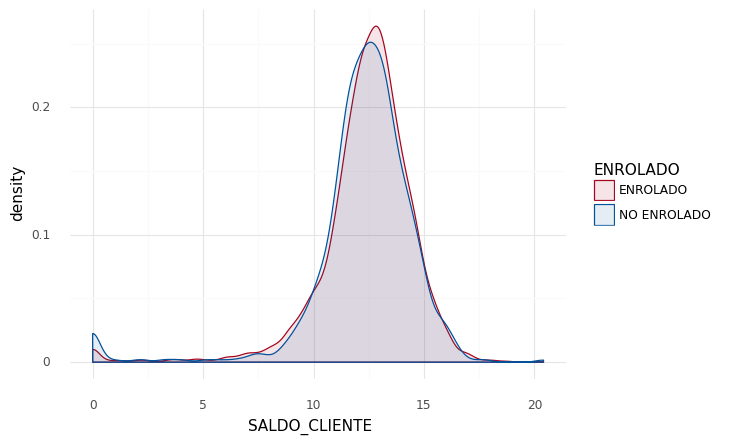

<ggplot: (-9223371926320416744)>

In [12]:
datos['SALDO_CLIENTE'] = np.log(datos['SALDO_CLIENTE'] + 1) # para precision numerica
ggplot(datos, aes(x='SALDO_CLIENTE', fill='ENROLADO', color='ENROLADO')) + geom_density(alpha=0.1 ) + theme_minimal() +\
scale_fill_manual(colores[[0,2]]) + scale_color_manual(colores[[0,2]]) 

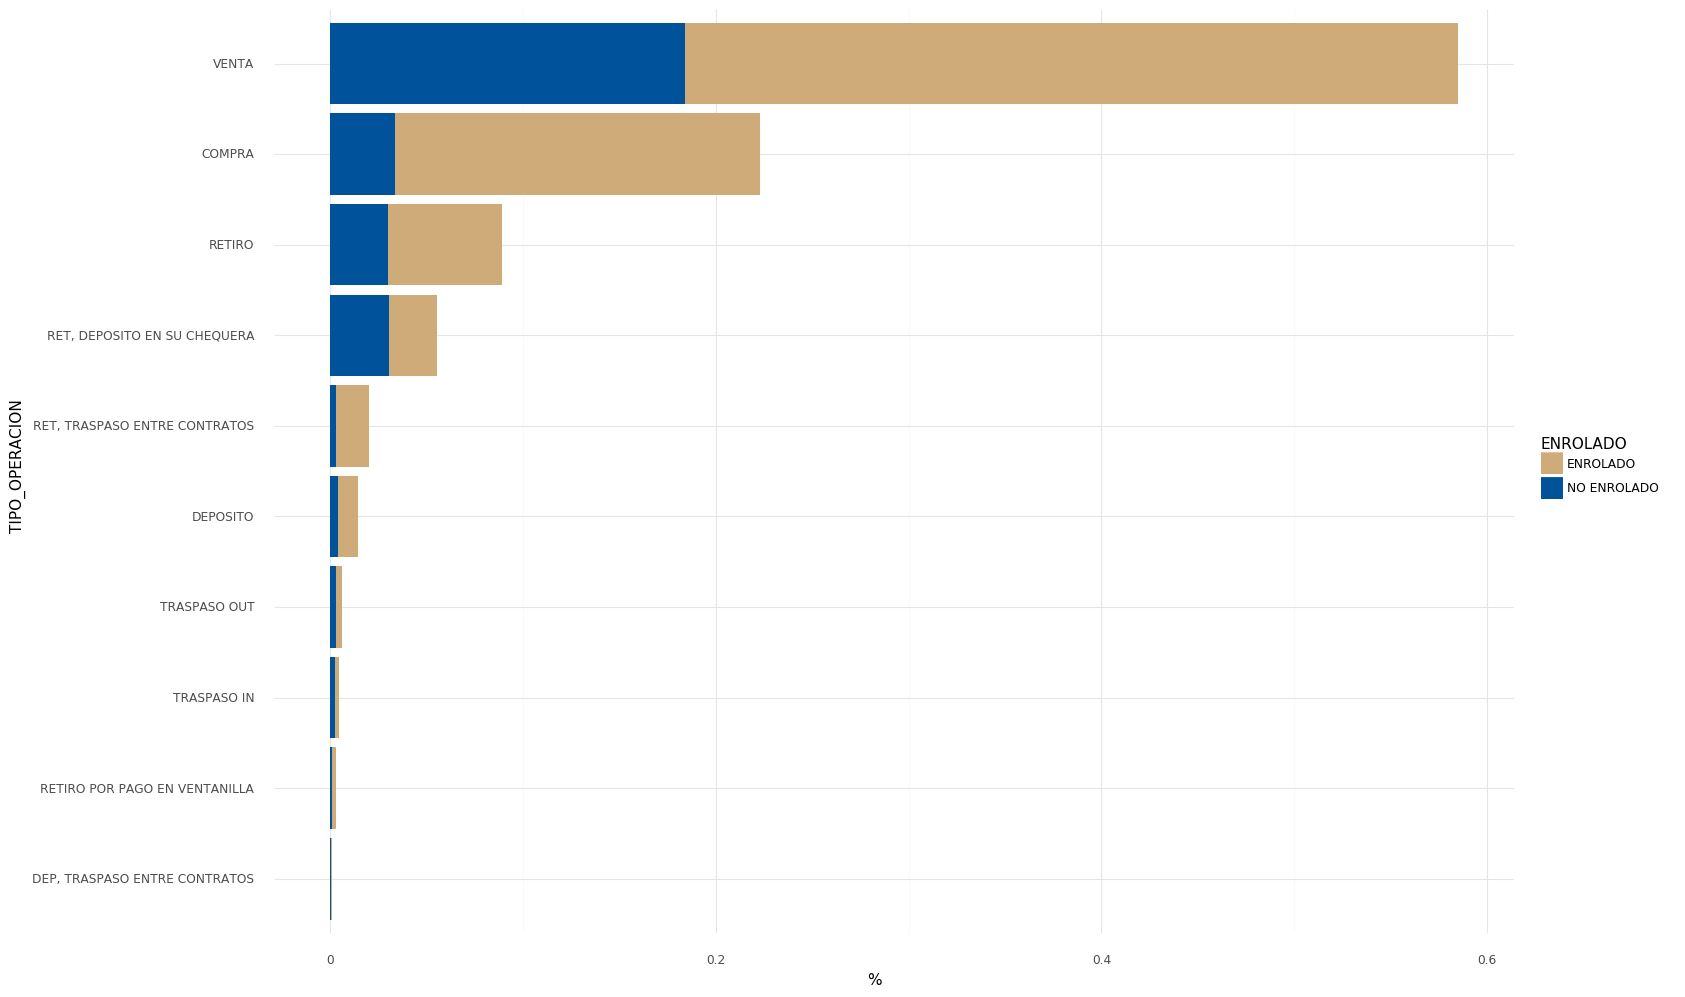

<ggplot: (-9223371926320777660)>

In [13]:
datos['TIPO_OPERACION'] =  datos['TIPO_OPERACION'].apply(lambda x : x.strip())
temp = datos['TIPO_OPERACION'].value_counts().index.tolist()[::-1]
ggplot(datos) + aes(x='TIPO_OPERACION', y = '(..count..)/sum(..count..)',  fill='ENROLADO')  + geom_bar()  +\
  scale_x_discrete(limits=temp) + ylab('%') + theme_minimal() + \
     theme(  figure_size=(16, 12)) + \
     coord_flip() + scale_fill_manual(colores[1:3])

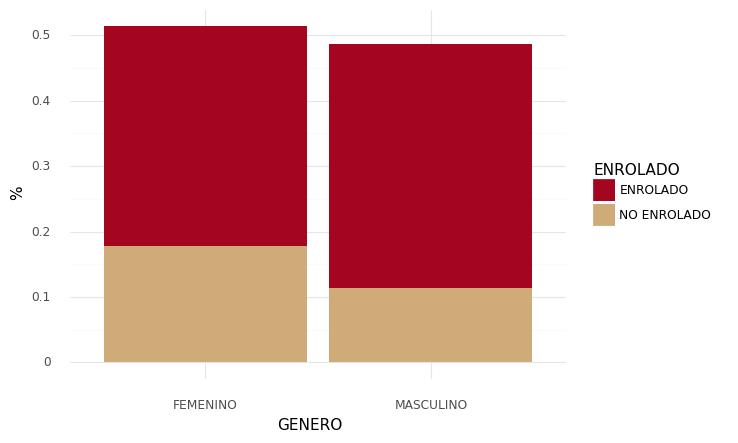

<ggplot: (-9223371926320847056)>

In [14]:
ggplot(datos, aes(x='GENERO' , fill='ENROLADO')) + \
     geom_bar(aes(y = '(..count..)/sum(..count..)')) + \
     theme_minimal() + ylab('%') + scale_fill_manual(colores[0:2])

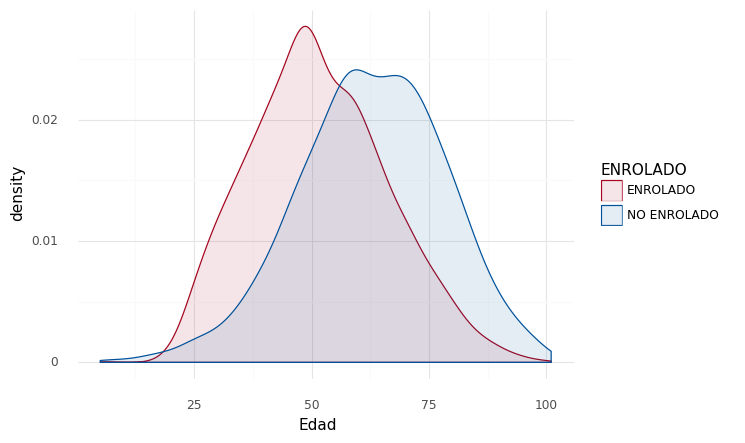

<ggplot: (-9223371926320777516)>

In [15]:
ggplot(datos, aes(x='Edad', fill='ENROLADO', color='ENROLADO')) + geom_density(alpha=0.1 ) + theme_minimal() +\
scale_fill_manual(colores[[0,2]]) + scale_color_manual(colores[[0,2]]) 

# Baseline

Consideremos un escenario base para comparar nuestro modelo final de clasificación que refleje qué clientes tienen mayor probabilidad de utilizar los servicios de banca electrónica (aquí __sí hablamos de intervalos de probabilidad!__, consultar libro pág. 3 sección `1.1.2 Bayesian Inference in Practice`) considerando solo la variable el género del cliente.

Partiendo de que sabemos que la distribución conjugada de una $Beta (\alpha, \beta)$ con una $X\sim Binomial(N,p)$ (en nuestro caso definimos el éxito como que la persona use los servicios electrónicos con probabilidad $p$) es una distribución $Beta(\alpha+X, \beta+N-X)$ (consultar libro pág. 164), generamos el siguiente escenario: 

   - Un enfoque sin información, una distribución uniforme para la proporción de clientes con banca electrónica activa. Por lo que partimos de una distribución a priori $Beta(1,1)$, y obtengamos la probabilidad de que un cliente use los servicios electrónicos. 


In [16]:
empirico = datos.groupby(['ENROLADO', 'GENERO']).size().reset_index(name='counts')
empirico

,ENROLADO,GENERO,counts
0,ENROLADO,FEMENINO,2525
1,ENROLADO,MASCULINO,2807
2,NO ENROLADO,FEMENINO,1340
3,NO ENROLADO,MASCULINO,850


In [17]:
import pymc3 as pm
from scipy.stats import beta
np.random.seed(seed=0)
''' funciones para desplegar resultados'''
#figsize(12,8)
def _hist(data, label, color, **kwargs):
    a = plt.hist(data, bins=80, density=True, histtype='stepfilled', alpha=.7, label=label, **kwargs, color=color)
    return(a)

def plot_traces(traces, retain=0):
    '''
    Grafica las cadenas muestreadas con  valores medios y superpuestos
    '''
    ax = pm.traceplot(traces[-retain:], legend=True,
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.5f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color=colores[0])


''' funciones utiles'''
def relative_increase(a,b):
    return (a-b)/b


In [18]:
# estimaciones muestrales
digitales_fem = empirico.counts[0]
digitales_mas = empirico.counts[1]
fems = np.sum(empirico.counts[[0,2]]) 
mass = np.sum(empirico.counts[[1,3]]) 

# supuestos de la a priori uniforme
alpha_aprior = beta_apriori = 1
print(digitales_fem)
print(digitales_mas)
print(digitales_fem/fems  )
print(digitales_mas/mass  )


2525
2807
0.6532988357050453
0.7675690456658463


In [19]:
posterior_fem = beta( alpha_aprior + digitales_fem, beta_apriori + fems - digitales_fem)
posterior_mass = beta(alpha_aprior+ digitales_mas, beta_apriori + mass - digitales_mas)
muestra_size = len(datos)*10
print(muestra_size)

75220


In [20]:
sampling_post_fem = posterior_fem.rvs(muestra_size)
sampling_post_mas = posterior_mass.rvs(muestra_size)

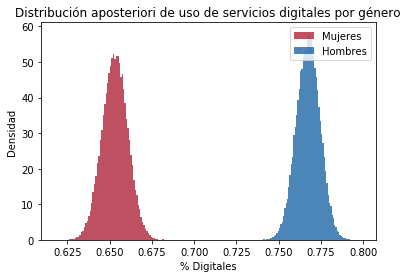

In [21]:
_hist(sampling_post_fem, 'Mujeres', colores[0])
_hist(sampling_post_mas, 'Hombres', colores[2])
plt.xlabel('% Digitales')
plt.ylabel('Densidad')
plt.title('Distribución aposteriori de uso de servicios digitales por género')
plt.legend(loc='upper right')

Donde podemos notar fácilmente que los hombres tienen mayor probabilidad de hacer uso de los servicios digitales, ahora calculemos un intervalo con __probabilidad__ de 95% sobre el número de veces que la proporción de hombres utilice los servicios digitales en comparación del de mujeres.  

No handles with labels found to put in legend.


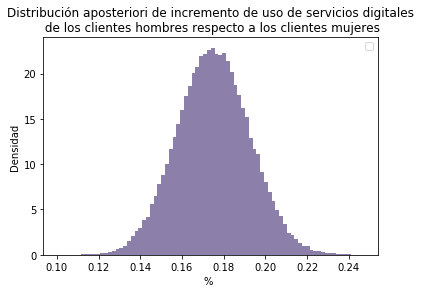

In [22]:
posterior_mayor_p_mas = relative_increase( sampling_post_mas, sampling_post_fem)
_hist(posterior_mayor_p_mas, '', color='#5C4985')
plt.xlabel('% ')
plt.ylabel('Densidad')
plt.title('Distribución aposteriori de incremento de uso de servicios digitales\n de los clientes hombres respecto a los clientes mujeres')
plt.legend(loc='upper right')

In [23]:
print('Intervalo de 95% de probabilidad de mayor uso de servicios digitales en hombres con respecto al de mujeres')
print( '[' + str( np.round(np.percentile(posterior_mayor_p_mas, q=.025) , 4)) + ','+\
      str( np.round(np.percentile(posterior_mayor_p_mas, q=.975) , 4)) + ']')

Intervalo de 95% de probabilidad de mayor uso de servicios digitales en hombres con respecto al de mujeres
[0.1142,0.1353]


# Creación de los modelos

En vista de que la mayoría de las columnas con las que trabajaremos son nominales vamos a realizar un cambio de encoding. Como tenemos algunas variables con más de 100 categorías en lugar de hacer dummies estas variables usaremos un encoding que mapea a cada categoría con un entero. 

In [24]:
cat_variables = datos.select_dtypes(['object']).columns
cat_variables = cat_variables[0:(len(cat_variables)-1)] # mantenemos a la variable objetivo como categorica

In [25]:
encoding = {}
for i in cat_variables:
    encoding[i] = pd.DataFrame( {'original':datos[i], 'encoding': datos[[i]].apply(lambda x: x.astype('category').cat.codes)[i] } ).drop_duplicates(['original', 'encoding'])
for i in ['SALDO_CLIENTE', 'Edad']:
    encoding[i] = pd.DataFrame( {'original':datos[i], 'encoding': datos[i]}).drop_duplicates()    
#
datos[cat_variables] = datos[cat_variables].apply(lambda x: x.astype('category').cat.codes)
    # normalizamos las variables para tener mayor estabilidad numerica
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
variables = ['UNIDAD_NEGOCIO', 'EMISORA_FONDO', 'DESC_CE_FINANCIERO', 'SALDO_CLIENTE', 'TIPO_OPERACION', 'GENERO', 'Edad']
scaler.fit(datos[variables])
datos[variables] = scaler.transform(datos[variables])
for i in encoding.keys():
    temp = StandardScaler()
    temp.fit( pd.DataFrame(encoding[i]['encoding']) )
    encoding[i]['encoding'] = temp.transform(pd.DataFrame(encoding[i]['encoding']) )

In [26]:
datos.head()
datos.describe()

,index,UNIDAD_NEGOCIO,EMISORA_FONDO,DESC_CE_FINANCIERO,SALDO_CLIENTE,TIPO_OPERACION,GENERO,Edad
count,7522.000000,7.522000e+03,7.522000e+03,7.522000e+03,7.522000e+03,7.522000e+03,7.522000e+03,7.522000e+03
mean,3766.645174,1.070903e-15,3.604314e-16,4.620333e-16,-5.059175e-16,4.524432e-15,-5.226697e-16,1.347263e-16
std,2173.086892,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00
min,0.000000,-3.665636e-01,-1.312303e+00,-1.532682e+00,-5.421978e+00,-1.611953e+00,-9.727197e-01,-3.166583e+00
25%,1885.250000,-3.665636e-01,-7.506625e-01,-7.624758e-01,-3.598939e-01,-8.163771e-01,-9.727197e-01,-6.852476e-01
50%,3766.500000,-3.665636e-01,-4.953711e-01,-3.773725e-01,1.125103e-01,7.747756e-01,-9.727197e-01,-4.900788e-02
75%,5648.750000,-3.665636e-01,5.768526e-01,2.002824e-01,5.504386e-01,7.747756e-01,1.028045e+00,7.144798e-01
max,7531.000000,2.728040e+00,4.048815e+00,2.510902e+00,3.528199e+00,7.747756e-01,1.028045e+00,2.941319e+00


In [27]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('ENROLADO ~ UNIDAD_NEGOCIO + EMISORA_FONDO + DESC_CE_FINANCIERO +\
                            SALDO_CLIENTE + TIPO_OPERACION +GENERO + Edad',
                            datos,
                            family=pm.glm.families.Binomial())
    step = pm.Metropolis()
    #trace = pm.sample(1000, tune=1000,  init='adapt_diag', step=step)
    trace = pm.sample(2000, tune=6000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Edad]
>Metropolis: [GENERO]
>Metropolis: [TIPO_OPERACION]
>Metropolis: [SALDO_CLIENTE]
>Metropolis: [DESC_CE_FINANCIERO]
>Metropolis: [EMISORA_FONDO]
>Metropolis: [UNIDAD_NEGOCIO]
>Metropolis: [Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 32000/32000 [04:50<00:00, 110.25draws/s]
The number of effective samples is smaller than 25% for some parameters.


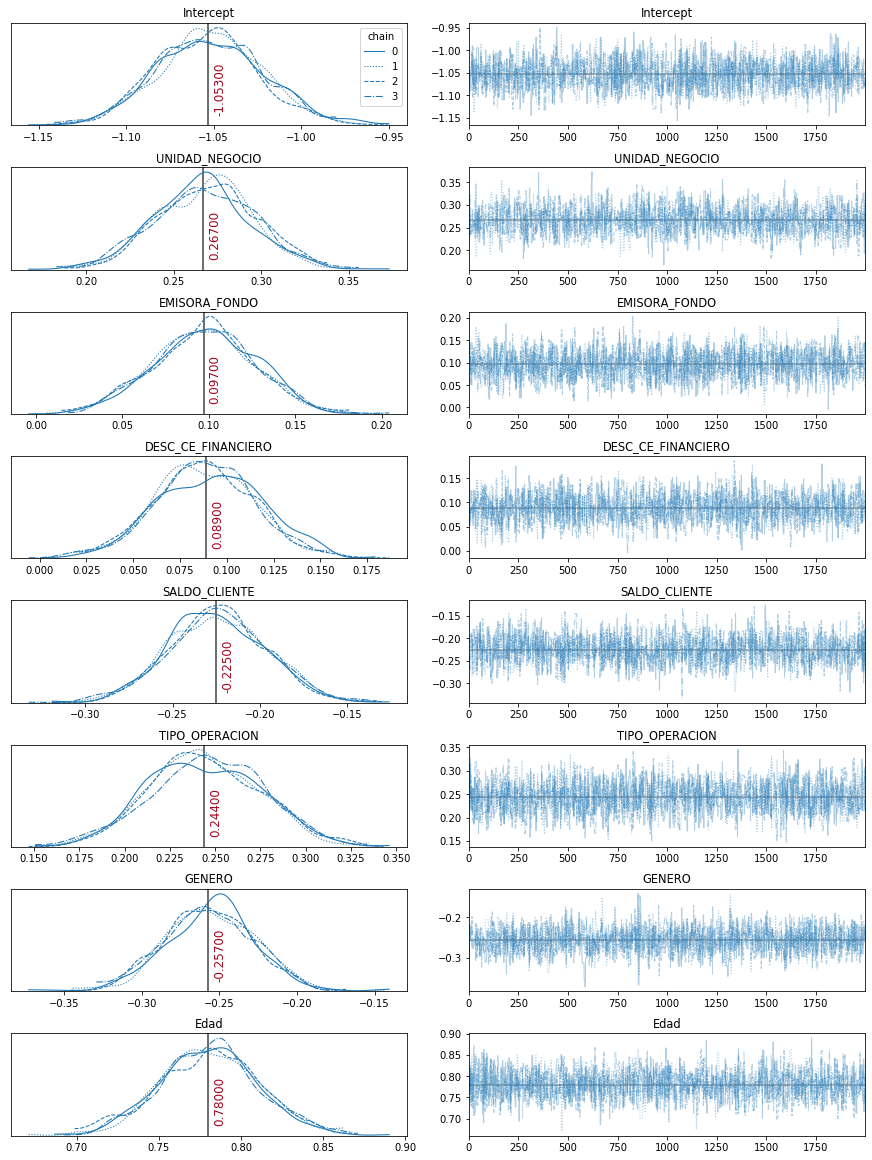

In [28]:
plot_traces(trace)

Las variables con mayor significancia son `Edad` y `GENERO` , veamos la distribución conjunta de las cadenas muestreadas

<Figure size 792x648 with 0 Axes>

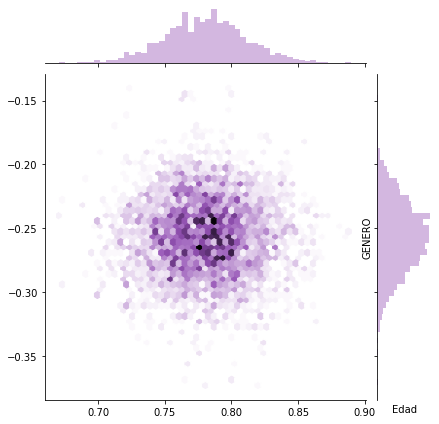

In [29]:
plt.figure(figsize=(11, 9))
seaborn.jointplot(trace['Edad'], trace['GENERO'], kind="hex", color="#914CB3")
plt.xlabel("Edad")
plt.ylabel("GENERO");

Y las menos significantes son `DESC_CE_FINANCIERO` y `EMISORA_FONDO`  veamos la distribución conjunta de las cadenas muestreadas

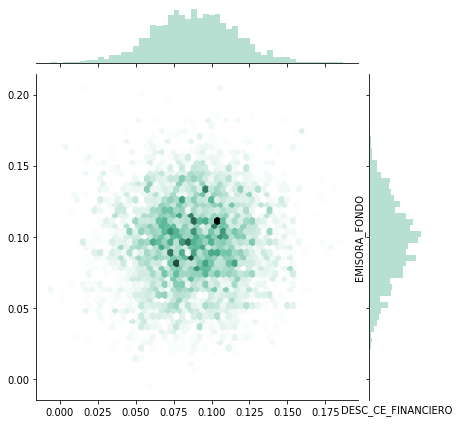

In [30]:
seaborn.jointplot(trace['DESC_CE_FINANCIERO'], trace['EMISORA_FONDO'], kind="hex", color="#4CB391")
plt.xlabel("DESC_CE_FINANCIERO")
plt.ylabel("EMISORA_FONDO");

In [31]:
encoding

{'UNIDAD_NEGOCIO':         original  encoding
 0          BANCO      -1.0
 6  CASA DE BOLSA       1.0,
 'EMISORA_FONDO':         original  encoding
 0        ACTIREN -1.192881
 1     CUENTA_EJE -0.506566
 2         ESCALA -0.277794
 4        ACTIGOB -1.421652
 6       EFECTIVO -0.310476
 ...          ...       ...
 5006  GLD         0.049022
 5008  LACOMER     0.310476
 5036  GE         -0.049022
 5555     NAFFP28  0.637292
 6431     AXESEDM -0.702656
 
 [106 rows x 2 columns],
 'DESC_CE_FINANCIERO':               original  encoding
 0     Ciudad de Mexico -1.024544
 13              Toluca  1.497410
 41           Queretaro  0.866921
 42              Merida  0.078811
 57          Hermosillo -0.551677
 64             Morelia  0.394055
 71          Cuernavaca -0.866921
 79                Leon -0.078811
 89            Saltillo  1.024544
 94           Monterrey  0.236433
 105            Jalisco -0.236433
 109     Aguascalientes -1.655032
 114          Chihuahua -1.339788
 115           Culi

In [32]:
''' funciones para evaluar la probabilidad a posterior conjunta '''
def LR_full(trace, Edad, UNIDAD_NEGOCIO, EMISORA_FONDO, DESC_CE_FINANCIERO, SALDO_CLIENTE, TIPO_OPERACION, GENERO):
    shape = np.broadcast( Edad, UNIDAD_NEGOCIO, EMISORA_FONDO, DESC_CE_FINANCIERO, SALDO_CLIENTE, TIPO_OPERACION, GENERO).shape
    x_norm = np.asarray( [ np.broadcast_to(x, shape) for x in [Edad, UNIDAD_NEGOCIO, EMISORA_FONDO, DESC_CE_FINANCIERO, SALDO_CLIENTE, TIPO_OPERACION, GENERO]])
    return 1 / (1 + np.exp(-(trace['Intercept'] + trace['UNIDAD_NEGOCIO']*x_norm[0] +
                             trace['EMISORA_FONDO']*(x_norm[1]) + trace['DESC_CE_FINANCIERO']*x_norm[2] +
                             trace['SALDO_CLIENTE']*x_norm[3]+ trace['TIPO_OPERACION']*x_norm[4]+ trace['GENERO']*x_norm[5] +
                             trace['Edad']*x_norm[6] )))
# Linear model with 'UNIDAD_NEGOCIO': 'BANCO'= -1.0
#'EMISORA_FONDO':  ACTIREN= -1.192881
# 'DESC_CE_FINANCIERO': 'Ciudad de Mexico' =-1.024544,
# 'TIPO_OPERACION':: VENTA = 1.566699 
# GENER:  MASCULINO = 1.0, 'SALDO_CLIENTE': 12.920457 = 0.223435
LR_mujeres = lambda x, samples: LR_full(samples, x,  -1.0, -1.192881, -1.024544, 1.566699, -1.0 , 0.223435 )
LR_hombres = lambda x, samples: LR_full(samples, x,  -1.0, -1.192881, -1.024544, 1.566699, 1.0 , 0.223435  )

Grafiquemos la probabilidad de que los clientes con puntos fijos para las variables `UNIDAD_NEGOCIO`, `EMISORA_FONDO`, `DESC_CE_FINANCIERO`, `TIPO_OPERACION`y `SALDO_CLIENTE`  y cambiando la variable `Edad` en el rango de la muestra y el género de los usuarios 

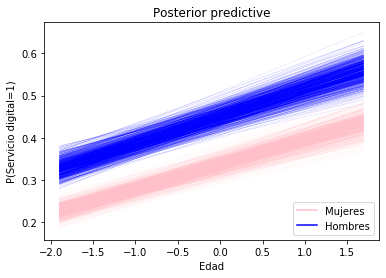

In [33]:
n = 2000
pm.plot_posterior_predictive_glm(trace, eval=np.random.choice([np.min(encoding['Edad']['encoding']), np.max(encoding['Edad']['encoding'])], n),
                                 lm=LR_mujeres, samples=1000, color="blue", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.random.choice([np.min(encoding['Edad']['encoding']), np.max(encoding['Edad']['encoding'])], n),
                                 lm=LR_hombres, samples=1000, color="pink", alpha=.15)
import matplotlib.lines as mlines
blue_line = mlines.Line2D(['LR_mujeres'], [], color='pink', label='Mujeres')
pink_line = mlines.Line2D(['LR_hombres'], [], color='blue', label='Hombres')
plt.legend(handles=[blue_line, pink_line], loc='lower right')
plt.ylabel("P(Servicio digital=1)")
plt.xlabel("Edad")
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Edad]
>Metropolis: [GENERO]
>Metropolis: [TIPO_OPERACION]
>Metropolis: [SALDO_CLIENTE]
>Metropolis: [UNIDAD_NEGOCIO]
>Metropolis: [Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 32000/32000 [03:35<00:00, 148.76draws/s]
The number of effective samples is smaller than 25% for some parameters.


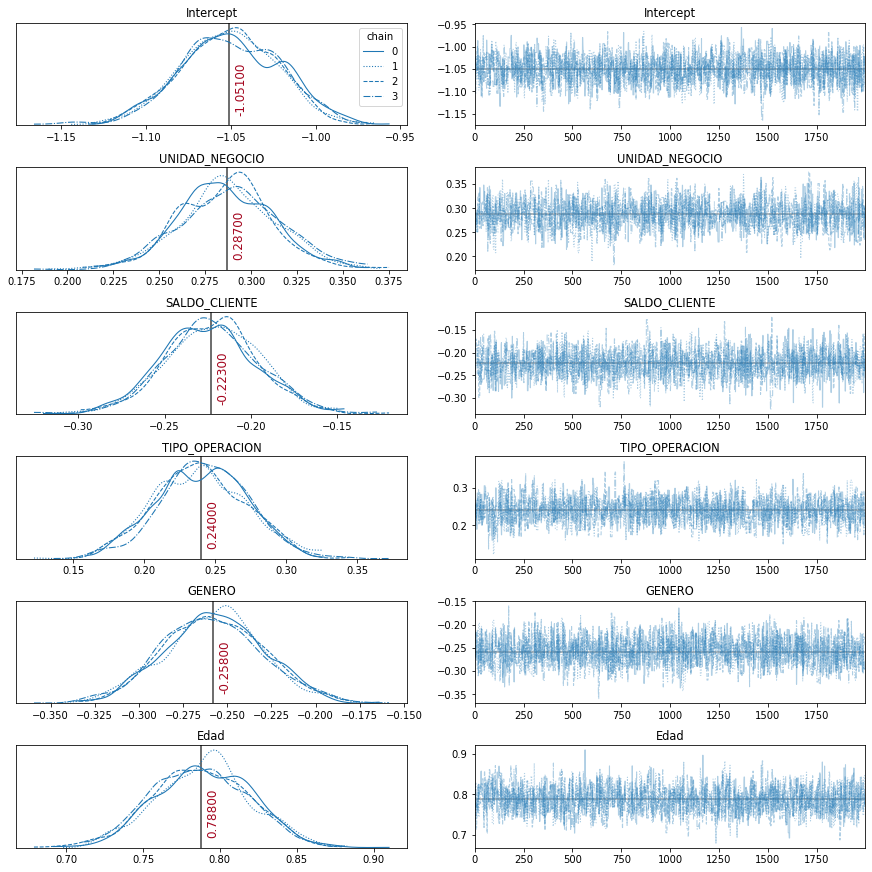

In [34]:
# probemos un modleo sin las variables menos significativas 'DESC_CE_FINANCIERO' y 'EMISORA_FONDO'
with pm.Model() as logistic_model_redox:
    pm.glm.GLM.from_formula('ENROLADO ~ UNIDAD_NEGOCIO + SALDO_CLIENTE + TIPO_OPERACION +GENERO + Edad',
                            datos,
                            family=pm.glm.families.Binomial())
    step = pm.Metropolis()
    #trace = pm.sample(1000, tune=1000,  init='adapt_diag', step=step)
    trace2 =pm.sample(2000, tune=6000, step=step)
plot_traces(trace2)

In [35]:
model_dict = { 'full': trace, 'redox':trace2}
dfwaic = pm.compare(model_dict, ic='WAIC', scale = 'deviance')

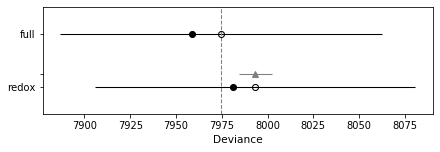

In [36]:
pm.compareplot(dfwaic); 

Sin embargo el modelo con todas las variables tiene una varianza menor por lo que lo elegimos sobre el modelo reducido

In [37]:
ppc = pm.sample_posterior_predictive(trace, samples=int(len(datos)), model=logistic_model)

C:\Users\fou-f\anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|█████████████████████████████████████████████████████████████████████████████| 7522/7522 [00:14<00:00, 508.19it/s]


In [38]:
len(ppc['y'][0])
print( (ppc['y'].shape) )

(7522, 7522)


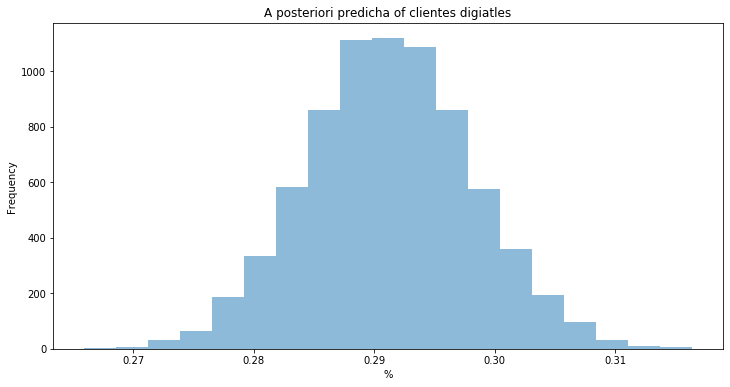

In [39]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['y']], bins=19, alpha=0.5)
ax.set(title='A posteriori predicha of clientes digiatles', xlabel='%', ylabel='Frequency');

### En conclusión verificamos con la regresión logística Bayesiana que el género de los cliente es una variable de suma importancia, además en comparación con el modelo baseline la tasa incremento se encuentre en el siguiente intervalo con una probabilidad de 95%

In [40]:
print('Intervalo de 95% de probabilidad de mayor uso de servicios digitales')
print( '[' + str( np.round(np.percentile([n.mean() for n in ppc['y']], q=.025) , 4)) + ','+\
      str( np.round(np.percentile([n.mean() for n in ppc['y']], q=.975) , 4)) + ']')

Intervalo de 95% de probabilidad de mayor uso de servicios digitales
[0.2686,0.2756]
